In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import ase
import glob
import tqdm
import numpy as np
import ase.io as aio

from toolz.curried import pipe, curry, compose

In [3]:
from sklearn.decomposition import PCA

In [4]:
import filters
import stats as astat
import utilities as utils

In [5]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [6]:
from ase import Atoms 
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

runs = np.loadtxt("runs.txt").astype(int)

In [8]:
cutoff = 17.0
r_stat = 15.0
len_pixel = 10.0 

r_s = 1.0 # radius of the smoothening filter
width = 0.25 # smoothening for the RDF function

In [9]:
new_shape = np.asarray([int(2 * r_stat * len_pixel + 1) + int(2 * r_s * len_pixel)]*3)

fs = pipe(r_s, 
          lambda r_s: filters.sphere(r_s * len_pixel),
          lambda s: utils.padder(s, new_shape), 
          lambda s: filters.imfilter(arg1=s, arg2=s) / np.count_nonzero(s))

smooth_box = compose(lambda s: filters.imfilter(arg1=s, arg2=fs), 
                     lambda s: utils.padder(s, new_shape))

smooth_sig = curry(lambda sig, w, bins: filters.convolve_kernel(kernel_arr=filters.epanechnikov_kernel(width=w, 
                                                                                                 x=bins), 
                                                          sig=sig))(w=width)

In [10]:
rdf_list = []
tpt_list = []
n_atoms_irr = []

for run in tqdm.tqdm_notebook(runs):
    atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(run), 
             lambda f: utils.load_file(f), 
             lambda a: get_atoms(a))

    idx = np.where(atoms.get_tags() != 1)[0]
    print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))

    if len(idx) == 0:
        np.random.seed(81396)
        idx = np.random.randint(low=0, high=len(atoms), size=2000)

    coords_all = atoms.get_positions()
    coords_sub = coords_all[idx]

    f_stat = "data/stats_new/dump.arc.{}_stat.pkl".format(run)
    stat = utils.load_file(f_stat)
    
    rdf_list.append(smooth_sig(bins=stat["bins"])(stat["pdf"]))
    tpt_list.append(smooth_box(stat["box"]))
    n_atoms_irr.append(stat["n_irr"])

/storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


total atoms: 4000000, disturbed atoms: 0
total atoms: 4000000, disturbed atoms: 87589
total atoms: 4000000, disturbed atoms: 132505
total atoms: 4000000, disturbed atoms: 171079
total atoms: 4000000, disturbed atoms: 182610
total atoms: 4000000, disturbed atoms: 189780
total atoms: 4000000, disturbed atoms: 207399
total atoms: 4000000, disturbed atoms: 206487
total atoms: 4000000, disturbed atoms: 205043
total atoms: 4000000, disturbed atoms: 242254
total atoms: 4000000, disturbed atoms: 244316
total atoms: 4000000, disturbed atoms: 274957
total atoms: 4000000, disturbed atoms: 272163
total atoms: 4000000, disturbed atoms: 259587
total atoms: 4000000, disturbed atoms: 259220
total atoms: 4000000, disturbed atoms: 254992
total atoms: 4000000, disturbed atoms: 289464
total atoms: 4000000, disturbed atoms: 277355
total atoms: 4000000, disturbed atoms: 266384
total atoms: 4000000, disturbed atoms: 261720
total atoms: 4000000, disturbed atoms: 252704
total atoms: 4000000, disturbed atoms: 2

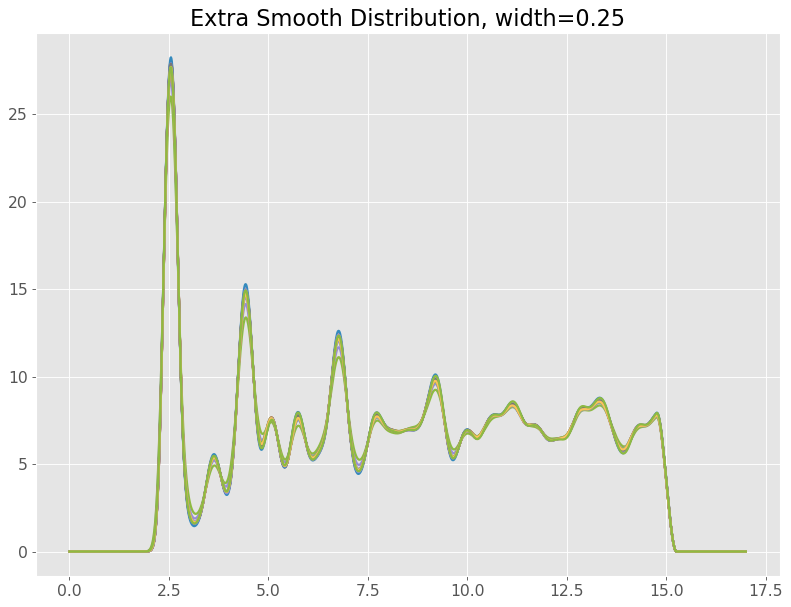

In [11]:
for i in np.random.randint(1, len(rdf_list), 20):
    plt.plot(stat["bins"], rdf_list[i])
plt.title("Extra Smooth Distribution, width=0.25")
plt.show()

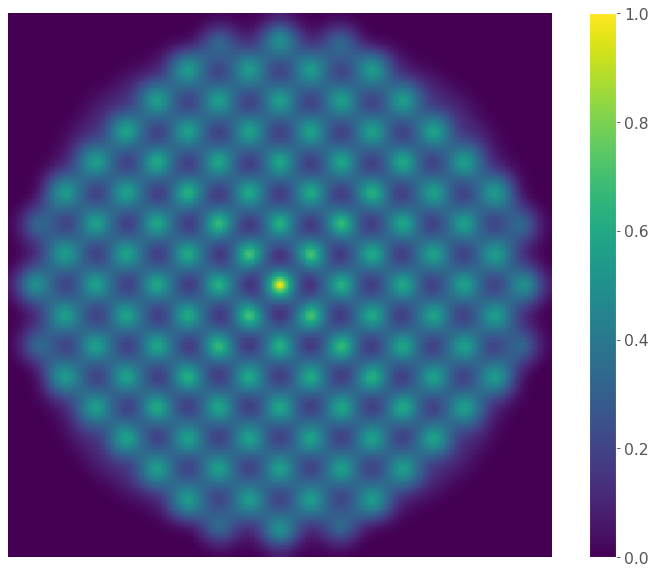

In [12]:
idx = int((r_stat + r_s) * len_pixel)
utils.draw_im(tpt_list[-10][:,:,idx])

## RDF in PC space

In [13]:
def compute_pca(x_data, n_comp=10, vis=True, labels=None, tag=""):
    
    pca = PCA(n_components=n_comp)
    scores = pca.fit_transform(x_data)

    if vis:
        ex_var = pca.explained_variance_ratio_ * 100
        plt.bar(np.arange(1, n_comp+1), ex_var)
        plt.ylim([0, 100])
        for ix, item in enumerate(ex_var):
            plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
        plt.title("Explained variance plot {}".format(tag))
        plt.grid(b=None)
        plt.show()
        

        if labels is None:
            labels = np.arange(1, len(scores)+1)
            
        plt.scatter(scores[:,0], scores[:,1], c=labels, s=labels)
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.grid(b=None)
        plt.title("PC space representation {}".format(tag))
        plt.show()
        
        plt.scatter(scores[:,1], scores[:,2], c=labels, s=labels)
        plt.xlabel("PC 2")
        plt.ylabel("PC 3")
        plt.grid(b=None)
        plt.title("PC space representation {}".format(tag))
        plt.show()
        
    return scores, pca

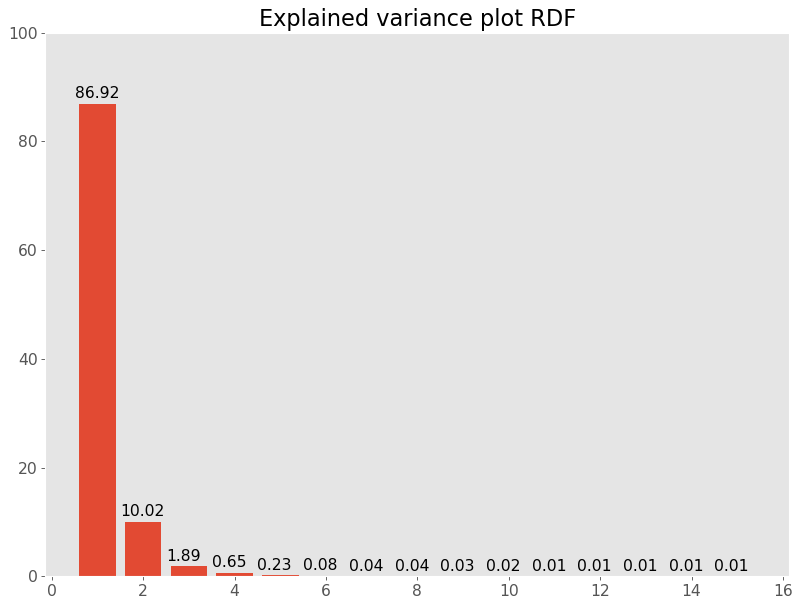

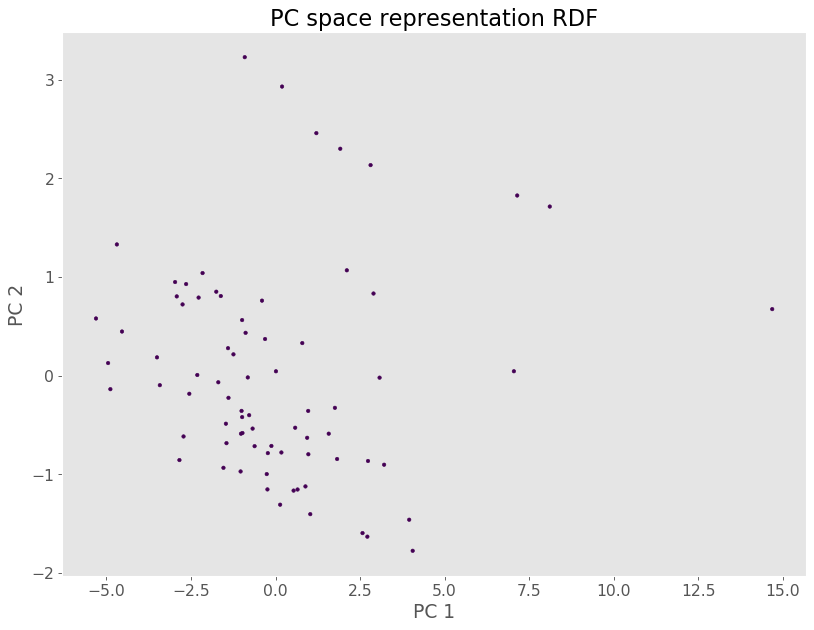

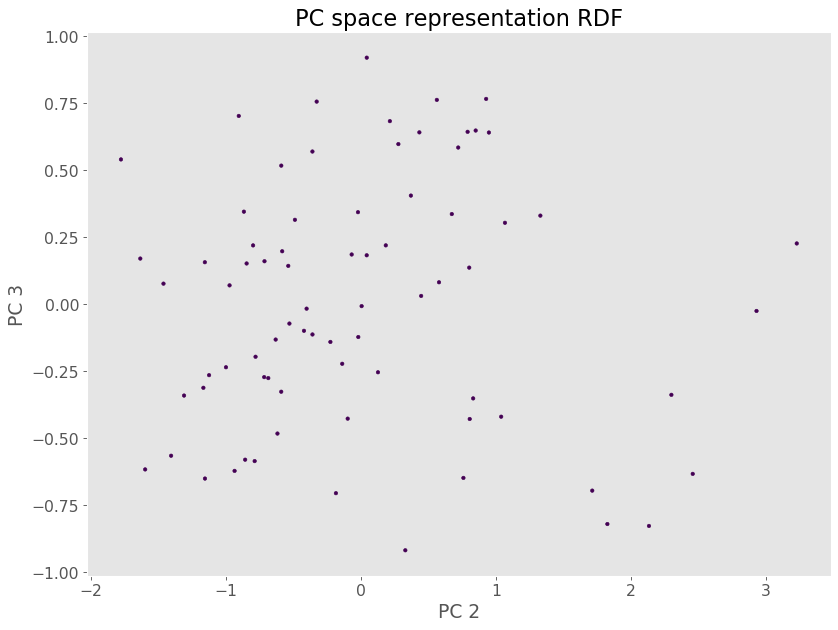

In [14]:
labels = [10]*len(rdf_list)
labels[0] = 100

x_data_rdf = np.concatenate([item[None] for item in rdf_list], axis=0)
scores_rdf, pca_rdf = compute_pca(x_data_rdf[1:], n_comp=15, tag="RDF", labels=labels[1:])

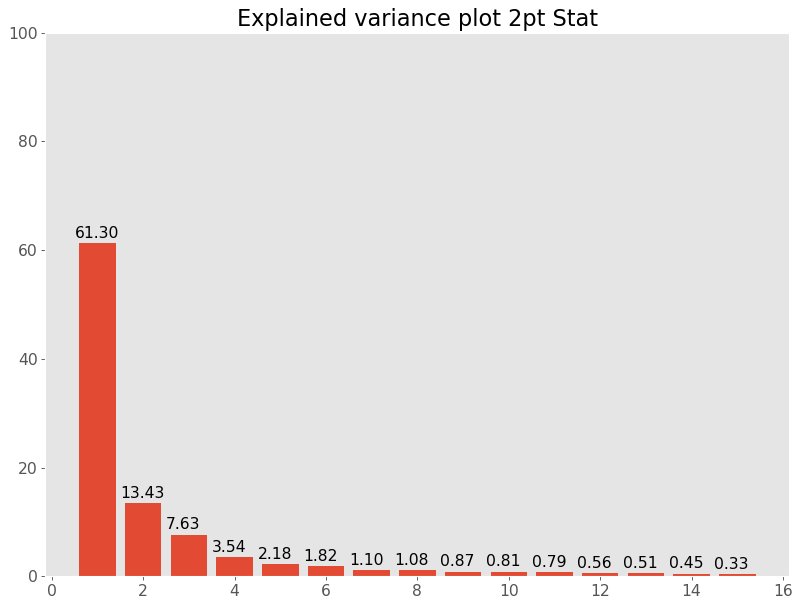

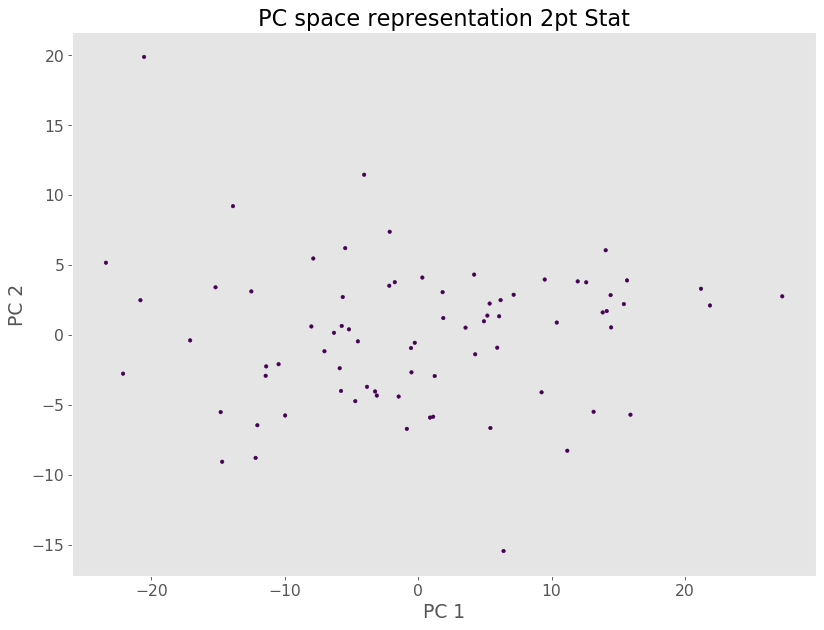

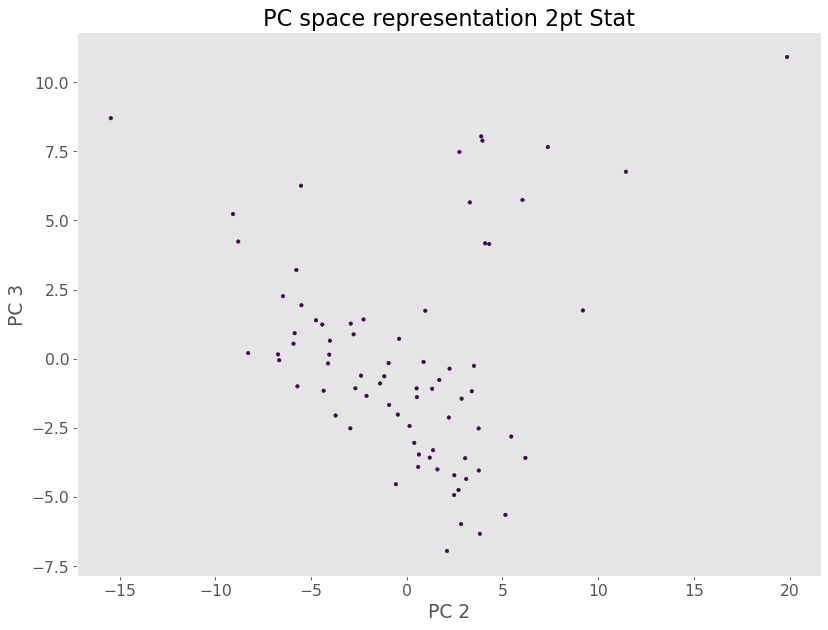

CPU times: user 12min, sys: 1min, total: 13min
Wall time: 2min 59s


In [15]:
%%time
labels = [10]*len(rdf_list)
labels[0] = 100

x_data_tpt = np.concatenate([np.ravel(item)[None] for item in tpt_list], axis=0)
scores_tpt, pca_tpt = compute_pca(x_data_tpt[1:], n_comp=15, tag="2pt Stat", labels=labels[1:])

## Correlation with SAED

In [16]:
img_saed_h = pipe("data/saed_masked_imgs_hid.pkl", 
                  utils.load_file,
                  lambda lst: [np.ravel(x)[None] for x in lst], 
                  curry(np.concatenate)(axis=0))

img_saed_c = pipe("data/saed_masked_imgs.pkl", 
                  utils.load_file,
                  lambda lst: [np.ravel(x)[None] for x in lst], 
                  curry(np.concatenate)(axis=0))

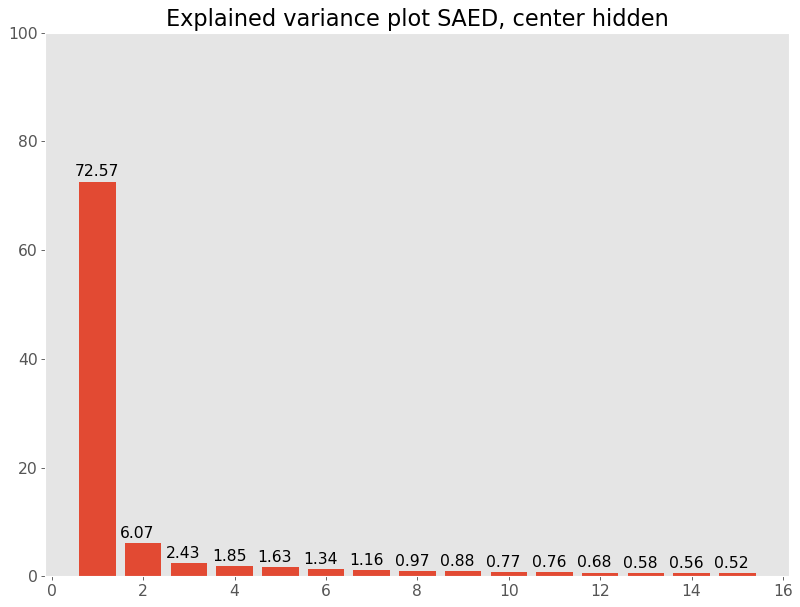

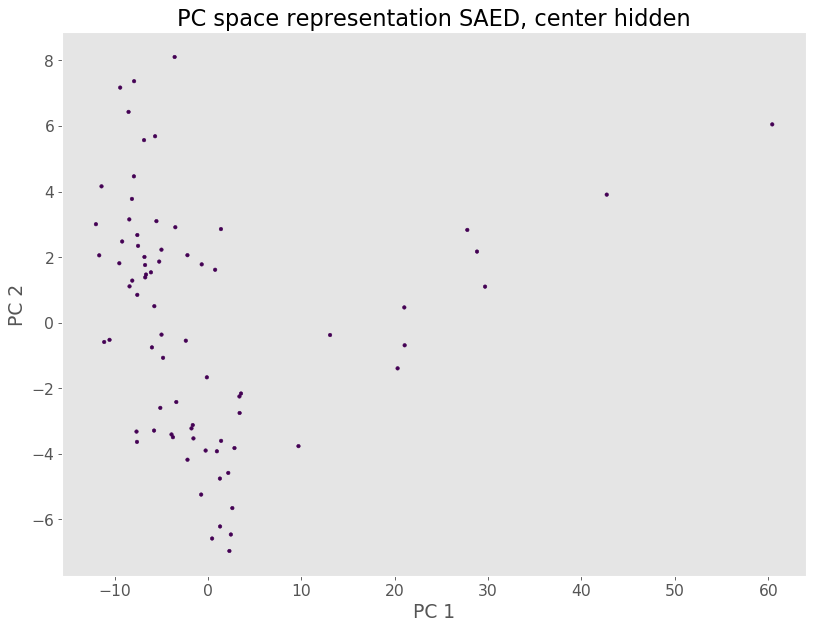

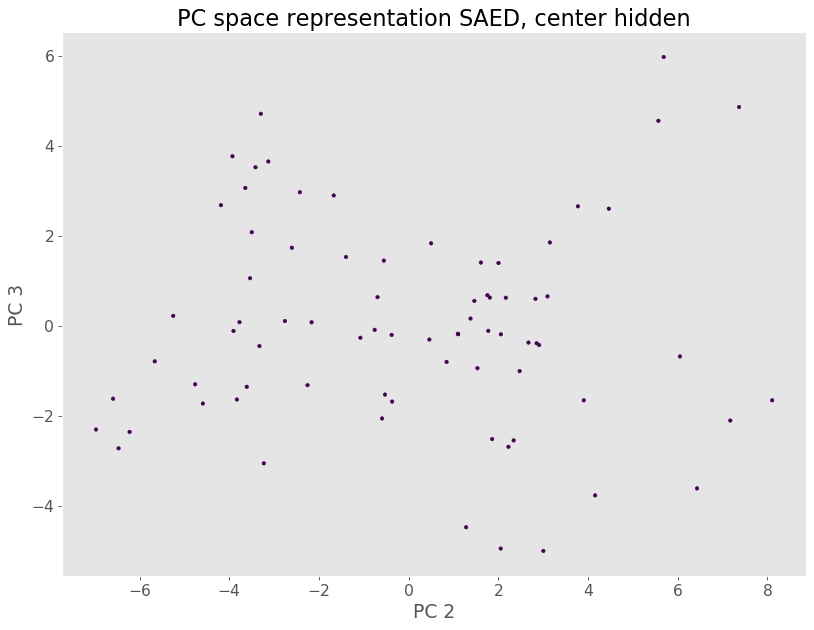

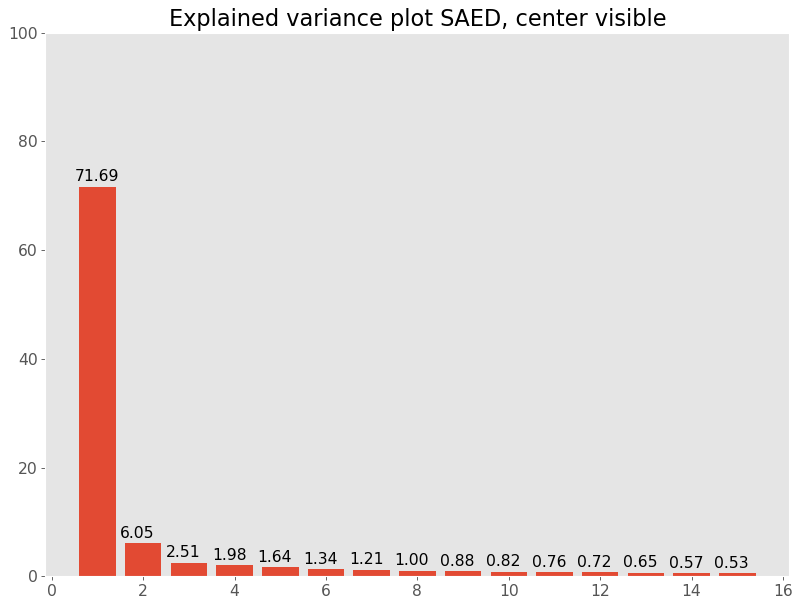

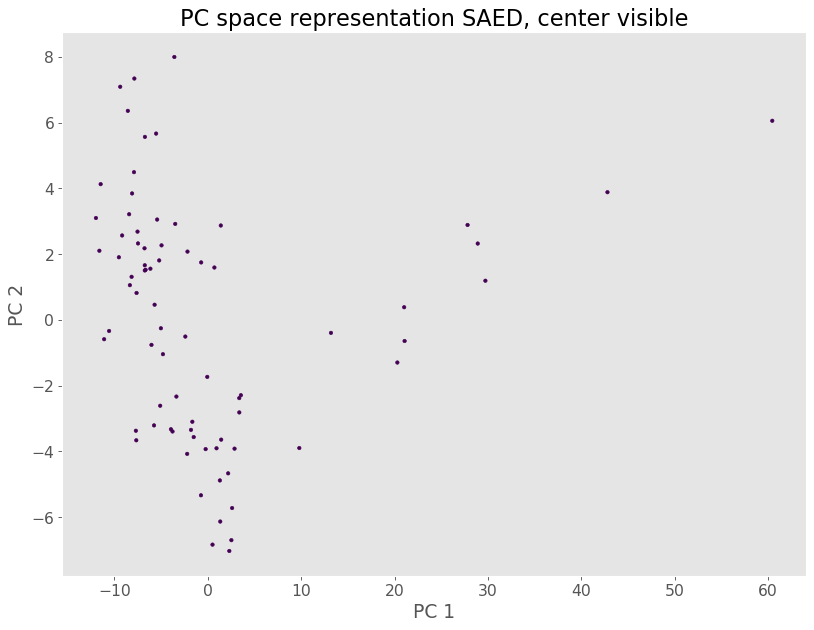

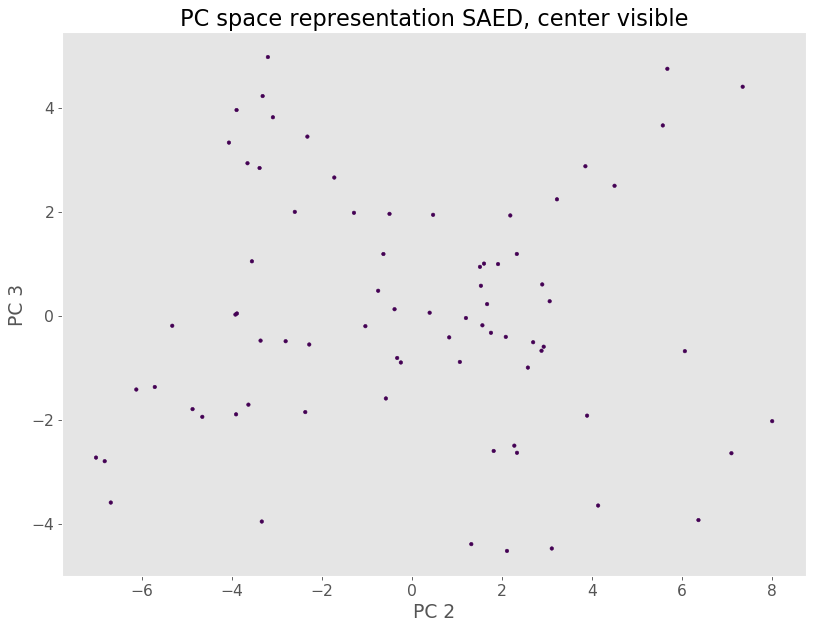

In [17]:
ix = 1
scores_saed_h, pca_saed_h = compute_pca(img_saed_h[ix:], n_comp=15, tag="SAED, center hidden", labels=labels[ix:])
scores_saed_c, pca_saed_c = compute_pca(img_saed_c[ix:], n_comp=15, tag="SAED, center visible", labels=labels[ix:])

In [52]:
def plot_corrs(x, y, title=""):
    corrs = []
    N = x.shape[1]
    for ix in range(N):
        corrs.append(np.fabs(np.corrcoef(x[:,ix], y)[0,1]))
        
    plt.bar(np.arange(N), corrs)
    plt.title(title)
    plt.show()

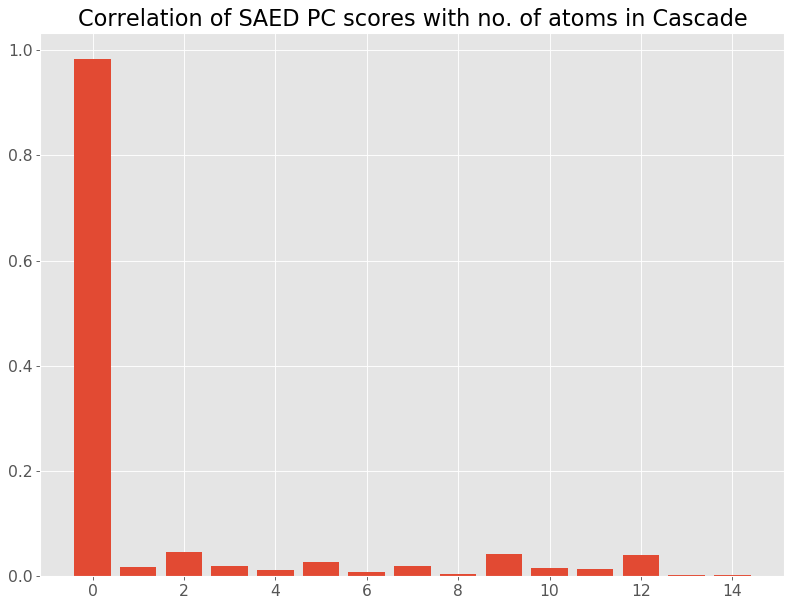

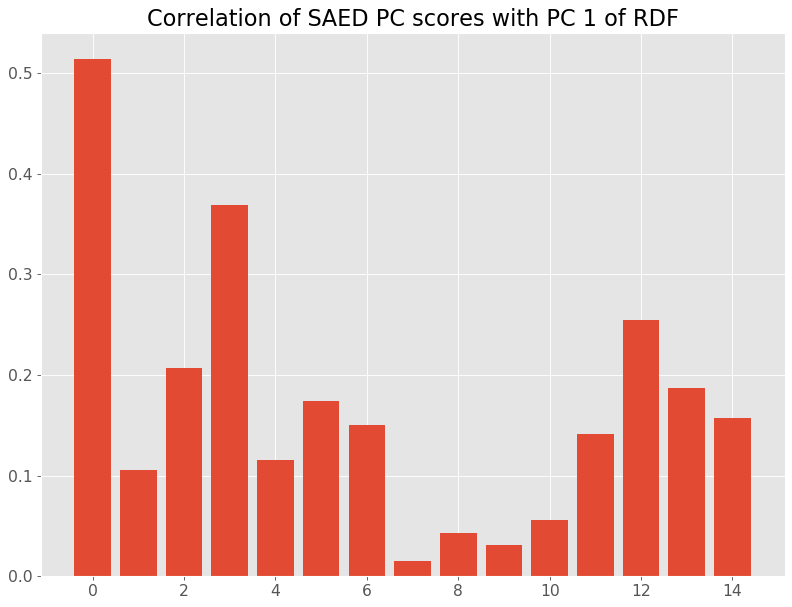

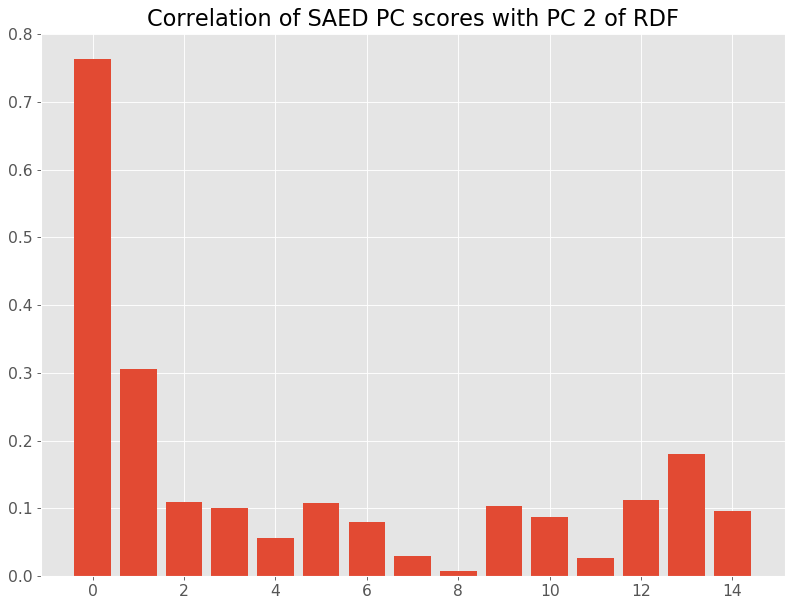

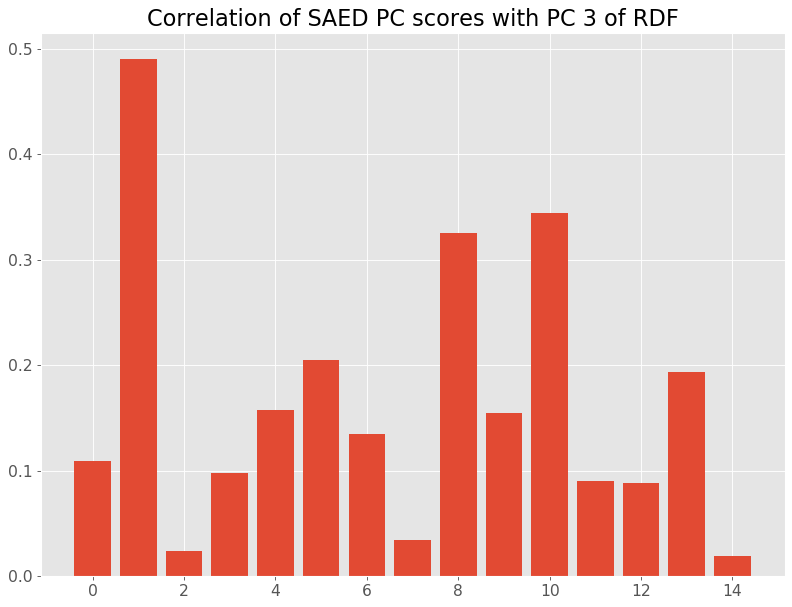

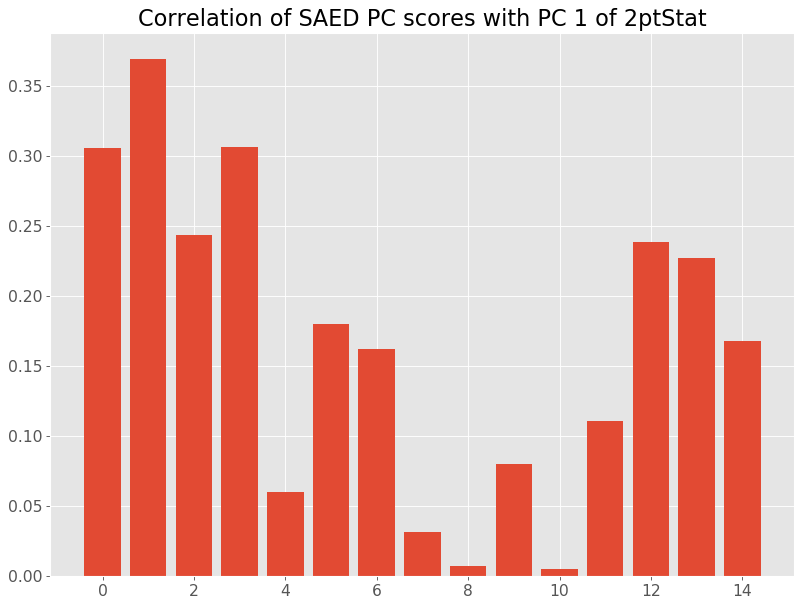

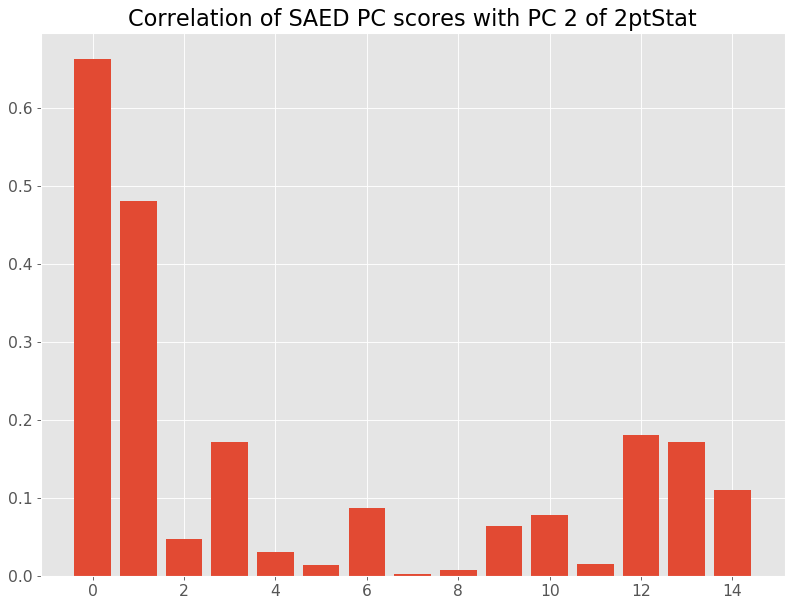

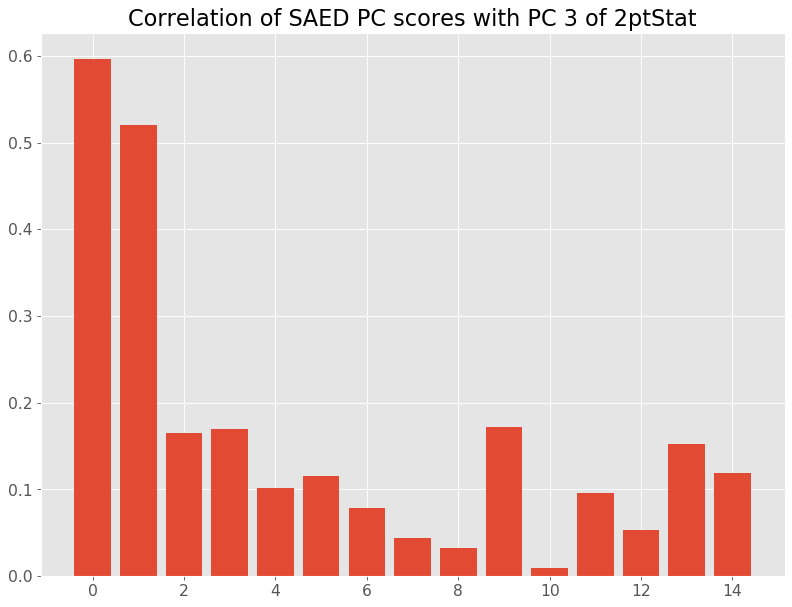

In [55]:
plot_corrs(x=scores_saed_h, y=n_atoms_irr[1:], 
           title="Correlation of SAED PC scores with no. of atoms in Cascade")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,0], 
           title="Correlation of SAED PC scores with PC 1 of RDF")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,1], 
           title="Correlation of SAED PC scores with PC 2 of RDF")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,2], 
           title="Correlation of SAED PC scores with PC 3 of RDF")

plot_corrs(x=scores_saed_h, y=scores_tpt[:,0], 
           title="Correlation of SAED PC scores with PC 1 of 2ptStat")

plot_corrs(x=scores_saed_h, y=scores_tpt[:,1], 
           title="Correlation of SAED PC scores with PC 2 of 2ptStat")

plot_corrs(x=scores_saed_h, y=scores_tpt[:,2], 
           title="Correlation of SAED PC scores with PC 3 of 2ptStat")

In [56]:
import GPy
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, BayesianRidge

In [57]:
maerror = lambda y1, y2: np.mean(np.fabs(y1-y2))

get_rbf_kernel = curry(lambda dim, var, scl, ard: GPy.kern.RBF(input_dim=dim, 
                                                    variance=var, 
                                                    lengthscale=scl, 
                                                    ARD=ard))

@curry
def gpr_trn(x_data, y_data, scl=1.0, var=1.0, ard=True):
    
    if type(scl) is not list:
        scl = [scl] * x_data.shape[1] if ard else scl
    
    kernel = get_rbf_kernel(dim=x_data.shape[1], var=var, scl=scl, ard=ard)
    
    model = GPy.models.GPRegression(x_data, y_data, kernel)
    model.optimize();
    return model, kernel


@curry
def gpr_prd(x_data, model):
    y_prd, y_var = model.predict(x_data)
    return y_prd, np.sqrt(y_var)


@curry
def get_pca(x_data, n_comp):
    pca = PCA(n_components=n_comp)
    f_data = pca.fit(x_data)
    return pca


def get_smooth_rdf(width):
    
    rdfs = np.load("rdfs/rdf_spiky_7_200_.npy")
    
    if width > 0.0:
        bins = np.linspace(0, 7.0, rdfs.shape[1]+1)
        bin_centers = (bins[1:] + bins[:-1]) * 0.5
        kernel = epanechnikov_kernel(width=width, x=bin_centers)
        rdfs_smooth = convolve_kernel(kernel, rdfs)
        return rdfs_smooth
    else:
        return rdfs
    

@curry
def gpr_model_full(X_data, y_data, n_splits=5, n_repeats=10, seed=2652124, scl=None, var=None):

    X = X_data.copy()
    y = y_data.copy()

    rkf = RepeatedKFold(n_splits=n_splits, 
                        n_repeats=n_repeats, 
                        random_state=seed)
    
    generator = rkf.split(X)

    errs_mae = []
    errs_gpr = []

    for ix, (trn_indx, tst_indx) in enumerate(generator):

        X_trn, X_tst = X[trn_indx], X[tst_indx]
        y_trn, y_tst = y[trn_indx], y[tst_indx]

        pca = get_pca(X_trn, n_comp=15)

        transformer_x = lambda x: pca.transform(x)
        transformer_y = lambda y: y

        x_inp = transformer_x(X_trn)
        y_inp = transformer_y(y_trn)
        
        if var is None:
            var = np.var(y_inp)
            
        if scl is None:
            scl = list(np.sqrt(pca.explained_variance_))
        
        try:
            gpr, rbf = gpr_trn(x_inp, y_inp, 
                               scl=scl, 
                               var=var, 
                               ard=True)

            y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                                       gpr)

            errs_mae.append(maerror(y_prd_m, y_tst))
        except Exception as err:
            print(err)
        
    return errs_mae, errs_gpr

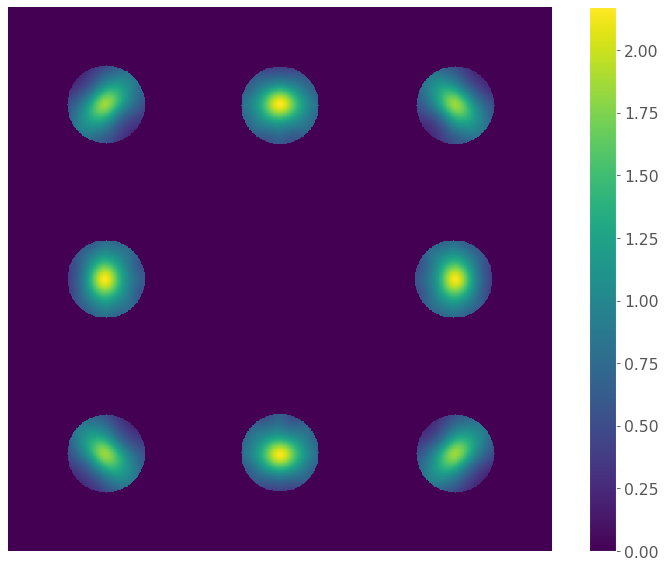

In [58]:
img_saed_list = utils.load_file("data/saed_masked_imgs_hid.pkl")
# img_saed_list = utils.load_file("data/saed_masked_imgs.pkl")
img_saed = np.concatenate([np.ravel(im)[None] for im in img_saed_list], axis=0)

utils.draw_im(img_saed_list[0])

In [ ]:
def get_model(X, y, model)
    rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
    generator = rkf.split(X)

    errs_mae = []

    for ix, (trn_indx, tst_indx) in enumerate(generator):

        X_trn, X_tst = X[trn_indx], X[tst_indx]
        y_trn, y_tst = y[trn_indx], y[tst_indx]

        model.fit(X_trn, y_trn)

        y_prd_m = model.predict(X_tst)

        y_prd_m_ = model.predict(X_trn)

        errs_mae.append(maerror(y_prd_m, y_tst))

    print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
    print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(y)))

    lims = [min(y), max(y)]
    plt.plot(y_trn, y_prd_m_, "r*")
    plt.plot(y_tst, y_prd_m, "g*")
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

    plt.tight_layout()
    plt.grid(False)
    plt.show()

test set mae: mean:6089.89569, std:1163.76401
Normalized mae: 0.02233


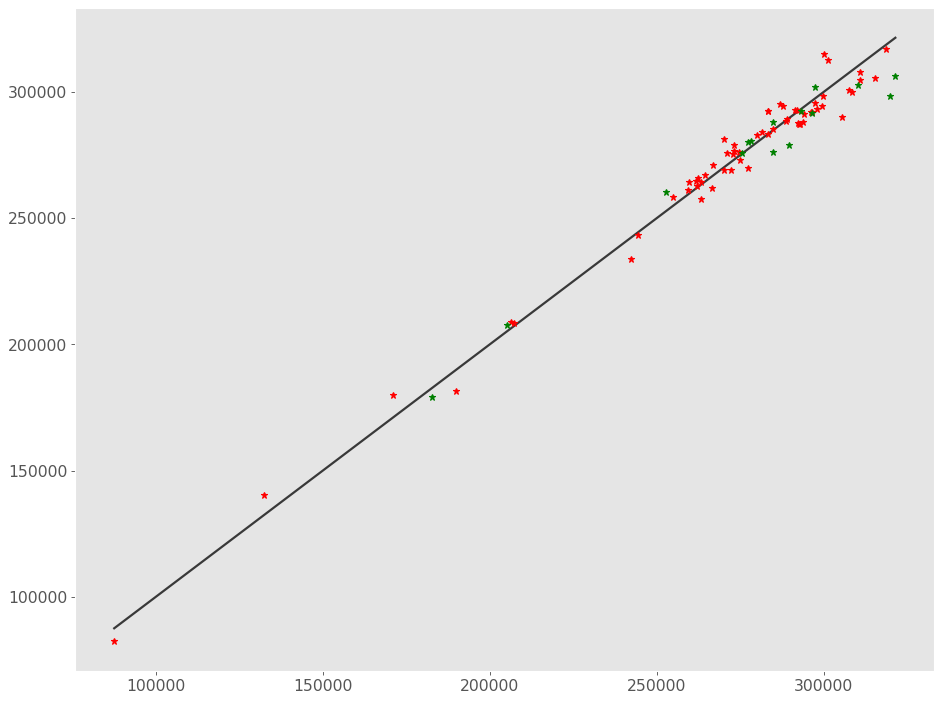

In [62]:
pca = PCA(n_components=15)
X = pca.fit_transform(img_saed_h[1:])
y = np.asarray(n_atoms_irr[1:])[...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []

for ix, (trn_indx, tst_indx) in enumerate(generator):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]
    
    model = Ridge(alpha=10.0)
    model.fit(X_trn, y_trn)
    
    y_prd_m = model.predict(X_tst)

    y_prd_m_ = model.predict(X_trn)

    errs_mae.append(maerror(y_prd_m, y_tst))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(y)))

lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.tight_layout()
plt.grid(False)
plt.show()

test set mae: mean:1.92959, std:0.47257
Normalized mae: 0.88073


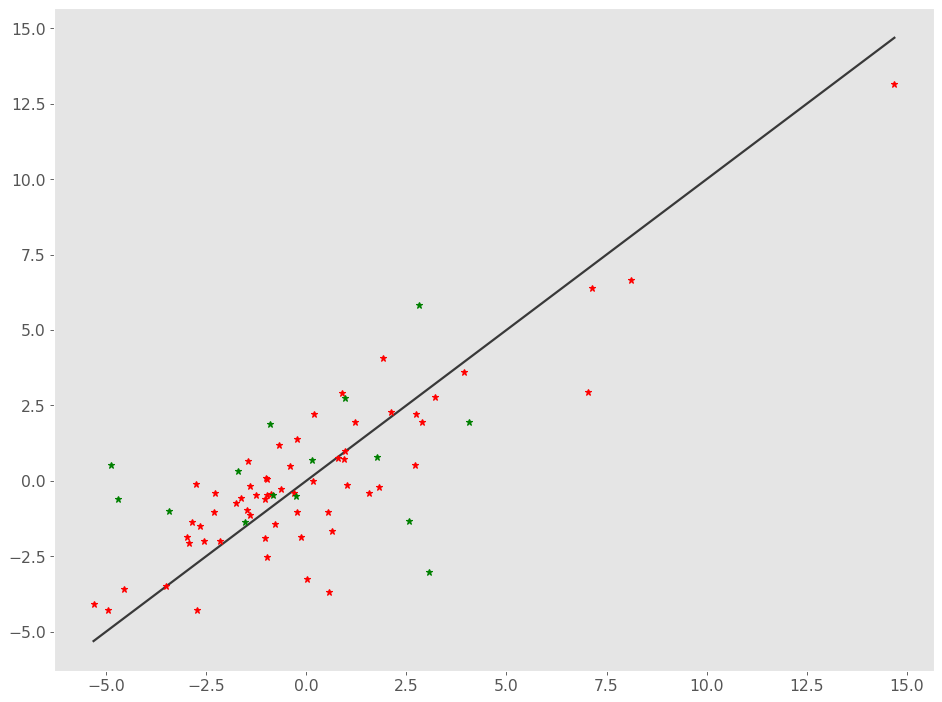

In [67]:
X = scores_saed_h
y = scores_rdf[:,0]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []

for ix, (trn_indx, tst_indx) in enumerate(generator):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]
    
    model = Ridge(alpha=1.0)
    model.fit(X_trn, y_trn)
    
    y_prd_m = model.predict(X_tst)

    y_prd_m_ = model.predict(X_trn)

    errs_mae.append(maerror(y_prd_m, y_tst))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(np.fabs(y))))

lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.tight_layout()
plt.grid(False)
plt.show()

 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide



test set mae: mean:1.99823, std:0.54671
Normalized mae: 0.91206


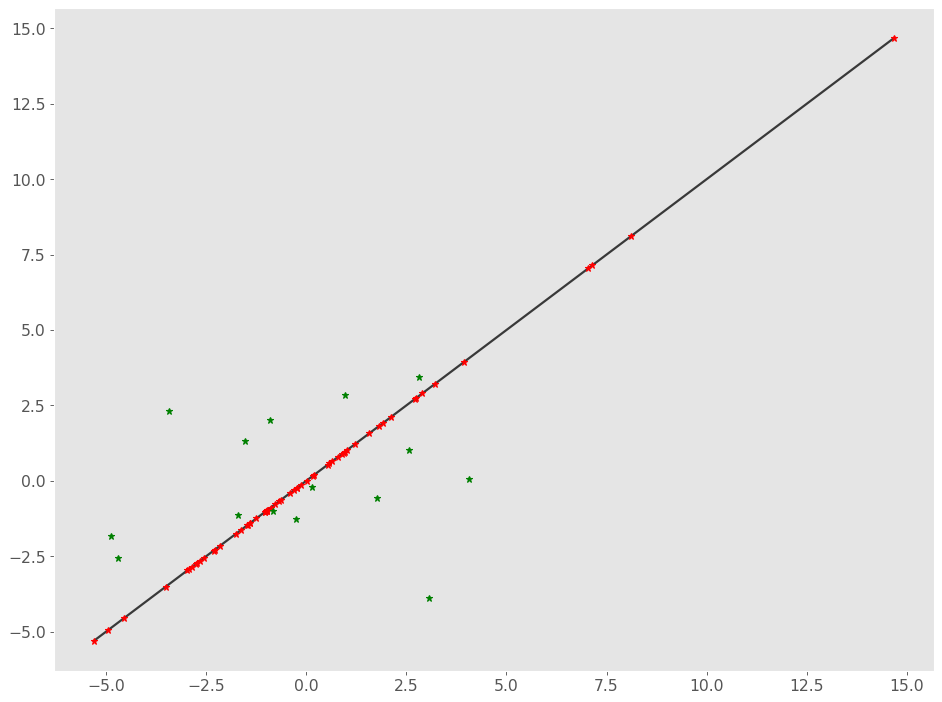

In [72]:
X = scores_saed_h
y = scores_rdf[:,0][...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []
errs_gpr = []

for ix, (trn_indx, tst_indx) in enumerate(tqdm.tqdm_notebook(generator)):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]


    transformer_x = lambda x: x
    transformer_y = lambda y: y

    x_inp = transformer_x(X_trn)
    y_inp = transformer_y(y_trn)

    gpr, rbf = gpr_trn(x_inp, y_inp, 
                       scl=[1.0]*X.shape[1], 
                       var=np.var(y_trn), 
                       ard=True)

    y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                               gpr)

    y_prd_m_, _ = gpr_prd(transformer_x(X_trn), 
                               gpr)

    errs_mae.append(maerror(y_prd_m, y_tst))
    errs_gpr.append(np.mean(y_prd_s))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(np.fabs(y))))


lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

# plt.xlim(lims)
# plt.ylim(lims)
plt.tight_layout()
plt.grid(False)
plt.show()

 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide



test set mae: mean:2.06258, std:0.42601
Normalized mae: 0.48825


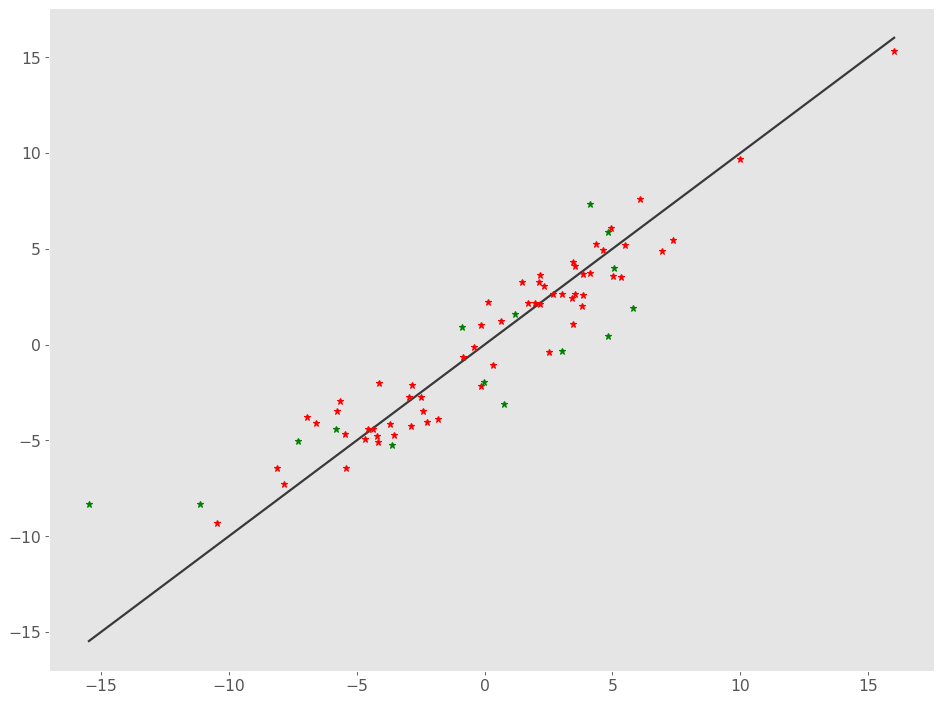

In [208]:
X = scores_saed_h
y = scores_rdf[:,0][...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2652124)
generator = rkf.split(X)

errs_mae = []
errs_gpr = []

for ix, (trn_indx, tst_indx) in enumerate(tqdm.tqdm_notebook(generator)):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]


    transformer_x = lambda x: x
    transformer_y = lambda y: y

    x_inp = transformer_x(X_trn)
    y_inp = transformer_y(y_trn)

    gpr, rbf = gpr_trn(x_inp, y_inp, 
                       scl=[1.0]*X.shape[1], 
                       var=np.var(y_trn), 
                       ard=True)

    y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                               gpr)

    y_prd_m_, _ = gpr_prd(transformer_x(X_trn), 
                               gpr)

    errs_mae.append(maerror(y_prd_m, y_tst))
    errs_gpr.append(np.mean(y_prd_s))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(np.fabs(y))))


lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

# plt.xlim(lims)
# plt.ylim(lims)
plt.tight_layout()
plt.grid(False)
plt.show()